**Multiclass Example:**
- How to use tsfresh to extract and select useful features from timeseries in a multiclass classification example. 
- We use an example dataset of human activity recognition. The dataset consists of timeseries for 7352 accelerometer readings. Each reading represents an accelerometer reading for 2.56 sec at 50hz. 

In [1]:
import matplotlib.pylab as plt
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd

**Load and Visualize the data:**

In [2]:
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
# fetch the dataset
download_har_dataset()

In [3]:
df = load_har_dataset()

c:\Users\blais\Documents\ML\venv2\lib\site-packages\tsfresh\examples\har_dataset.py:82: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(data_file_name_dataset, delim_whitespace=True, header=None)


In [4]:
df.shape

(7352, 128)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,0.005407,0.006221,0.006895,0.004610,0.007331,0.005078,0.005763,0.006693,0.005443,0.008241,0.006506,0.006532,0.007422,0.005772,0.006240,0.004623,0.004833,0.005499,0.004341,0.005098,0.004269,0.003045,0.003204,0.004520,0.005127,0.003550,0.004234,0.004469,0.003573,0.005136,...,0.000389,0.001328,0.002053,0.002738,0.002743,0.001330,-0.000367,-0.000722,-0.001904,-0.004294,-0.000025,0.005251,0.002490,0.000811,0.001166,-0.000693,-0.000077,0.000504,-0.000495,0.000156,0.000065,-0.000320,0.000185,-0.000375,-0.001013,-0.001611,-0.001765,-0.000636,0.001047,0.003019,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,-0.000487,-0.000356,-0.000229,-0.000131,-0.000441,-0.001565,-0.000929,0.000009,-0.001236,-0.000911,-0.000435,-0.001177,0.000165,0.000751,0.000389,0.001328,0.002053,0.002738,0.002743,0.001330,-0.000367,-0.000722,-0.001904,-0.004294,-0.000025,0.005251,0.002490,0.000811,0.001166,-0.000693,...,-0.001506,-0.002105,-0.001494,0.002181,0.002876,0.000871,-0.000392,-0.000569,0.000569,-0.001176,-0.001957,-0.000471,0.000208,0.003380,0.004829,0.003380,0.001088,-0.001249,0.000387,0.000533,-0.000679,0.000594,-0.000084,-0.000142,0.000784,0.001507,0.003386,0.002166,0.000422,0.000854,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,-0.006476,-0.003423,-0.000610,-0.002929,-0.001796,0.000956,0.002311,0.002538,0.001180,0.001217,0.000869,0.000686,0.002156,0.000478,-0.001506,-0.002105,-0.001494,0.002181,0.002876,0.000871,-0.000392,-0.000569,0.000569,-0.001176,-0.001957,-0.000471,0.000208,0.003380,0.004829,0.003380,...,0.002138,0.003519,0.002715,0.002370,0.003299,0.002357,0.001481,-0.000340,-0.002201,0.000124,0.002345,0.002706,0.001281,-0.000949,0.000890,0.004952,0.007315,0.004242,-0.002776,-0.004625,-0.001945,0.002561,0.007382,0.005730,0.002901,0.002896,0.000533,0.000552,0.001286,-0.000926,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,-0.004482,0.004528,0.008167,0.002929,-0.004487,-0.004717,-0.001637,-0.000097,0.001614,0.002619,0.004765,0.005851,0.002579,0.000677,0.002138,0.003519,0.002715,0.002370,0.003299,0.002357,0.001481,-0.000340,-0.002201,0.000124,0.002345,0.002706,0.001281,-0.000949,0.000890,0.004952,...,0.001470,0.001644,-0.000106,-0.001683,-0.001165,0.000241,0.000216,-0.000102,-0.001546,-0.003518,-0.003204,-0.002376,-0.001825,-0.001754,-0.002504,-0.002612,-0.002715,-0.001748,0.000066,-0.000050,-0.000898,-0.001478,-0.000698,0.000441,-0.001206,-0.002607,-0.001986,-0.001230,-0.001129,-0.001334,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,0.001750,0.001420,0.000297,0.000665,0.001911,0.001778,0.001087,-0.000716,-0.001347,-0.000384,-0.000135,0.000666,0.000656,0.000221,0.001470,0.001644,-0.000106,-0.001683,-0.001165,0.000241,0.000216,-0.000102,-0.001546,-0.003518,-0.003204,-0.002376,-0.001825,-0.001754,-0.002504,-0.002612,...,-0.001015,0.001832,0.001169,0.000362,-0.002587,-0.002581,0.001470,0.003026,0.003734,0.001870,-0.000212,0.000945,0.001956,0.002602,0.001366,0.000665,-0.000459,-0.004151,-0.003591,-0.001328,-0.000153,0.001043,0.000407,-0.000614,-0.002858,-0.003824,-0.001411,0.000765,0.001153,0.000627,0.002529,0.003518,-0.000248,-0.002761,

In [5]:
y = load_har_classes()

c:\Users\blais\Documents\ML\venv2\lib\site-packages\tsfresh\examples\har_dataset.py:95: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(


In [8]:
y.shape

(7352,)

In [31]:
y.value_counts()

0
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64

The data is not in a typical time series format so far: the columns are the time steps where each row is a measurement of a different person. 
Therefore - we bring it to a format where the time series of different persons are identified by an id and are ordered by time vertically.

In [10]:
df['id'] = df.index

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,id
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,0.005407,0.006221,0.006895,0.004610,0.007331,0.005078,0.005763,0.006693,0.005443,0.008241,0.006506,0.006532,0.007422,0.005772,0.006240,0.004623,0.004833,0.005499,0.004341,0.005098,0.004269,0.003045,0.003204,0.004520,0.005127,0.003550,0.004234,0.004469,0.003573,0.005136,...,0.001328,0.002053,0.002738,0.002743,0.001330,-0.000367,-0.000722,-0.001904,-0.004294,-0.000025,0.005251,0.002490,0.000811,0.001166,-0.000693,-0.000077,0.000504,-0.000495,0.000156,0.000065,-0.000320,0.000185,-0.000375,-0.001013,-0.001611,-0.001765,-0.000636,0.001047,0.003019,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576,0
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,-0.000487,-0.000356,-0.000229,-0.000131,-0.000441,-0.001565,-0.000929,0.000009,-0.001236,-0.000911,-0.000435,-0.001177,0.000165,0.000751,0.000389,0.001328,0.002053,0.002738,0.002743,0.001330,-0.000367,-0.000722,-0.001904,-0.004294,-0.000025,0.005251,0.002490,0.000811,0.001166,-0.000693,...,-0.002105,-0.001494,0.002181,0.002876,0.000871,-0.000392,-0.000569,0.000569,-0.001176,-0.001957,-0.000471,0.000208,0.003380,0.004829,0.003380,0.001088,-0.001249,0.000387,0.000533,-0.000679,0.000594,-0.000084,-0.000142,0.000784,0.001507,0.003386,0.002166,0.000422,0.000854,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599,1
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,-0.006476,-0.003423,-0.000610,-0.002929,-0.001796,0.000956,0.002311,0.002538,0.001180,0.001217,0.000869,0.000686,0.002156,0.000478,-0.001506,-0.002105,-0.001494,0.002181,0.002876,0.000871,-0.000392,-0.000569,0.000569,-0.001176,-0.001957,-0.000471,0.000208,0.003380,0.004829,0.003380,...,0.003519,0.002715,0.002370,0.003299,0.002357,0.001481,-0.000340,-0.002201,0.000124,0.002345,0.002706,0.001281,-0.000949,0.000890,0.004952,0.007315,0.004242,-0.002776,-0.004625,-0.001945,0.002561,0.007382,0.005730,0.002901,0.002896,0.000533,0.000552,0.001286,-0.000926,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178,2
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,-0.004482,0.004528,0.008167,0.002929,-0.004487,-0.004717,-0.001637,-0.000097,0.001614,0.002619,0.004765,0.005851,0.002579,0.000677,0.002138,0.003519,0.002715,0.002370,0.003299,0.002357,0.001481,-0.000340,-0.002201,0.000124,0.002345,0.002706,0.001281,-0.000949,0.000890,0.004952,...,0.001644,-0.000106,-0.001683,-0.001165,0.000241,0.000216,-0.000102,-0.001546,-0.003518,-0.003204,-0.002376,-0.001825,-0.001754,-0.002504,-0.002612,-0.002715,-0.001748,0.000066,-0.000050,-0.000898,-0.001478,-0.000698,0.000441,-0.001206,-0.002607,-0.001986,-0.001230,-0.001129,-0.001334,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028,3
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,0.001750,0.001420,0.000297,0.000665,0.001911,0.001778,0.001087,-0.000716,-0.001347,-0.000384,-0.000135,0.000666,0.000656,0.000221,0.001470,0.001644,-0.000106,-0.001683,-0.001165,0.000241,0.000216,-0.000102,-0.001546,-0.003518,-0.003204,-0.002376,-0.001825,-0.001754,-0.002504,-0.002612,...,0.001832,0.001169,0.000362,-0.002587,-0.002581,0.001470,0.003026,0.003734,0.001870,-0.000212,0.000945,0.001956,0.002602,0.001366,0.000665,-0.000459,-0.004151,-0.003591,-0.001328,-0.000153,0.001043,0.000407,-0.000614,-0.002858,-0.003824,-0.001411,0.000765,0.001153,0.000627,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0

In [13]:
df = df.melt(id_vars = "id", var_name = "time").sort_values(["id","time"]).reset_index(drop=True)

In [14]:
df.head()

,id,time,value
0,0,0,0.000181
1,0,1,0.010139
2,0,2,0.009276
3,0,3,0.005066
4,0,4,0.010810


In [35]:
df['id'].nunique()

7352

In [16]:
df['time'].dtype

dtype('O')

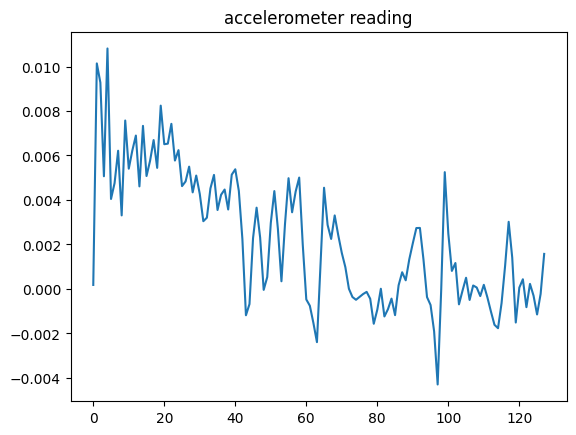

In [15]:
plt.title("accelerometer reading")
plt.plot(df[df['id'] == 0].set_index("time").value)
plt.show()

Rememeber the ids are measurements off different people. time and value - the acceleromenter readings over time as they carried out some activity.

**Extract Features:**

In [17]:
# use only the first 500 ids to speed up the processing
X = extract_features(df[df['id'] < 500], column_id = "id", column_sort = "time", impute_function = impute)

Feature Extraction: 100%|██████████| 39/39 [00:08<00:00,  4.47it/s]


In [36]:
X.shape

(500, 783)

In [18]:
X.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,value__mean,value__length,value__standard_deviation,value__variation_coefficient,value__variance,value__skewness,value__kurtosis,value__root_mean_square,value__absolute_sum_of_changes,value__longest_strike_below_mean,value__longest_strike_above_mean,value__count_above_mean,value__count_below_mean,value__last_location_of_maximum,value__first_location_of_maximum,value__last_location_of_minimum,value__first_location_of_minimum,value__percentage_of_reoccurring_values_to_all_values,value__percentage_of_reoccurring_datapoints_to_all_datapoints,value__sum_of_reoccurring_values,value__sum_of_reoccurring_data_points,value__ratio_value_number_to_time_series_length,value__sample_entropy,value__maximum,value__absolute_maximum,value__minimum,value__benford_correlation,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,...,value__number_crossing_m__m_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,value__energy_ratio_by_chunks__num_segments_10__segment_focus_1,value__energy_ratio_by_chunks__num_segments_10__segment_focus_2,value__energy_ratio_by_chunks__num_segments_10__segment_focus_3,value__energy_ratio_by_chunks__num_segments_10__segment_focus_4,value__energy_ratio_by_chunks__num_segments_10__segment_focus_5,value__energy_ratio_by_chunks__num_segments_10__segment_focus_6,value__energy_ratio_by_chunks__num_segments_10__segment_focus_7,value__energy_ratio_by_chunks__num_segments_10__segment_focus_8,value__energy_ratio_by_chunks__num_segments_10__segment_focus_9,value__ratio_beyond_r_sigma__r_0.5,value__ratio_beyond_r_sigma__r_1,value__ratio_beyond_r_sigma__r_1.5,value__ratio_beyond_r_sigma__r_2,value__ratio_beyond_r_sigma__r_2.5,value__ratio_beyond_r_sigma__r_3,value__ratio_beyond_r_sigma__r_5,value__ratio_beyond_r_sigma__r_6,value__ratio_beyond_r_sigma__r_7,value__ratio_beyond_r_sigma__r_10,value__count_above__t_0,value__count_below__t_0,value__lempel_ziv_complexity__bins_2,value__lempel_ziv_complexity__bins_3,value__lempel_ziv_complexity__bins_5,value__lempel_ziv_complexity__bins_10,value__lempel_ziv_complexity__bins_100,value__fourier_entropy__bins_2,value__fourier_entropy__bins_3,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,0.290392,0.001766,0.001435,0.000011,-0.000032,0.002025,0.002269,128.0,0.002941,1.296355,0.000009,0.486834,-0.363323,0.003714,0.182234,21.0,41.0,61.0,67.0,0.039062,0.031250,0.765625,0.757812,0.0,0.0,0.0,0.0,1.0,1.163942,0.010810,0.010810,-0.004294,0.816821,-2.848871e-09,-8.289268e-09,-1.655787e-08,...,0.0,0.335647,0.288817,0.139401,0.075869,0.062774,0.031116,0.008017,0.042908,0.004503,0.010949,0.742188,0.320312,0.085938,0.039062,0.015625,0.000000,0.0,0.0,0.0,0.0,0.703125,0.296875,0.210938,0.273438,0.335938,0.421875,0.687500,0.079487,0.079487,0.079487,0.419383,2.000401,1.747535,3.015811,4.068979,4.555721,4.724480,0.0,0.008684
1,0.0,0.0,0.0,0.0,0.022239,0.000506,0.001323,-0.000021,-0.000008,0.000110,0.000174,128.0,0.001981,11.401648,0.000004,-0.486496,1.580318,0.001989,0.167999,15.0,9.0,62.0,66.0,0.281250,0.273438,0.539062,0.531250,0.0,0.0,0.0,0.0,1.0,1.519826,0.005251,0.006706,-0.006706,0.983865,-5.877318e-10,-1.922393e-09,-4.718608e-10,...,0.0,0.110895,0.019683,0.157085,0.016659,0.062837,0.283357,0.066826,0.130860,0.045555,0.106242,0.515625,0.281250,0.140625,0.054

Train and Evaluate a Classifier:

for later comparison, we train a decision tree on all features (without selection)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y[:500], test_size = .2)

In [20]:
y_train.unique()

array([6, 2, 1, 4, 5, 3], dtype=int64)

In [21]:
y_test.unique()

array([3, 5, 4, 1, 6, 2], dtype=int64)

In [22]:
classifier_full = DecisionTreeClassifier()
classifier_full.fit(X_train, y_train)
print(classification_report(y_test, classifier_full.predict(X_test)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00         8
           4       0.56      0.45      0.50        20
           5       0.42      0.53      0.47        15
           6       0.57      0.57      0.57        14

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.77      0.76      0.76       100



**Multiclass feature selection:**
-  We will now select a subset of relevant features using the tsfresh select features method. However, it only works for binary classification or regression tasks. (reason is in what select features actually does - it ebaluates the statistical significance of features with respect to target variables. The reason it is explicitly documented to work for binary classication and regression tasks but not for multiclass classification, stems from the underlying statistical tests and implementation details in tsfresh.)
- For 6 label multi classification, we therefore split the selection problem into 6 binary one-versis all classification problems. For each of them, we can do a binary classification feature selection

In [23]:
relevant_features = set()

for label in y.unique():
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    print(f"Number of relevant features for class {label}: {X_train_filtered.shape[1]}/{X_train.shape[1]}")
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

Number of relevant features for class 5: 238/783
Number of relevant features for class 4: 219/783
Number of relevant features for class 6: 206/783
Number of relevant features for class 1: 238/783
Number of relevant features for class 3: 252/783
Number of relevant features for class 2: 163/783


In [24]:
len(relevant_features)

292

We keep only those features that we selected above, for both the train and test set

In [25]:
X_train_filtered = X_train[list(relevant_features)]
X_test_filtered = X_test[list(relevant_features)]

and try again.....

In [27]:
classifier_selected = DecisionTreeClassifier()
classifier_selected.fit(X_train_filtered, y_train)
print(classification_report(y_test, classifier_selected.predict(X_test_filtered)))

              precision    recall  f1-score   support

           1       1.00      0.93      0.96        27
           2       0.94      1.00      0.97        16
           3       0.89      1.00      0.94         8
           4       0.44      0.35      0.39        20
           5       0.41      0.47      0.44        15
           6       0.38      0.43      0.40        14

    accuracy                           0.69       100
   macro avg       0.68      0.70      0.68       100
weighted avg       0.69      0.69      0.69       100



Interesting - this one actually became worse when only relevant features were selected.

**Improved Multiclass feature selection:**
- We can instead specify the number of classes for which a feature should be a relevant predictor, in order to pass through the filtering process. This is as simple as setting the multiclass param to True and setting n_significant to the required number of classes.

In [28]:
X_train_filtered_multi = select_features(X_train, y_train, multiclass=True, n_significant=5)
X_train_filtered_multi.shape

(400, 193)

In [29]:
classifier_selected_multi = DecisionTreeClassifier()
classifier_selected_multi.fit(X_train_filtered_multi, y_train)
X_test_filtered_multi = X_test[X_train_filtered_multi.columns]
print(classification_report(y_test, classifier_selected_multi.predict(X_test_filtered_multi)))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98        27
           2       0.94      1.00      0.97        16
           3       1.00      1.00      1.00         8
           4       0.46      0.30      0.36        20
           5       0.42      0.53      0.47        15
           6       0.41      0.50      0.45        14

    accuracy                           0.71       100
   macro avg       0.71      0.72      0.71       100
weighted avg       0.71      0.71      0.71       100



In [32]:
y.value_counts()

0
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64

In [33]:
y_train.value_counts()

0
1    99
5    69
6    66
3    64
4    53
2    49
Name: count, dtype: int64

In [34]:
y_test.value_counts()

0
1    27
4    20
2    16
5    15
6    14
3     8
Name: count, dtype: int64